In [1]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
from getplate import getPlate
from getdisc import GetDisc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output
import matplotlib.animation as animation
from IPython.display import HTML, clear_output
from scipy.constants import Avogadro as avogadro

C:\Users\matss\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%%html 
<style>
.output_wrapper button.btn.btn-default, .output_wrapper .ui-dialog-titlebar {
    display: none;
} </style>

In [3]:
def quadratureTable2D(N):
    '''
    Takes in N, number of quadrature points and returns the quadrature 
    nodes and weights
    '''
    if N == 1:
        zeta = np.array([[1/3,1/3,1/3]])
        rho = np.array([1])
    elif N == 3:
        zeta = np.array([[1/2, 1/2, 0],
                        [1/2, 0, 1/2],
                        [0, 1/2, 1/2]])
        rho = np.array([1/3, 1/3, 1/3])
    elif N == 4:
        zeta = np.array([[1/3, 1/3, 1/3],
                      [3/5, 1/5, 1/5],
                      [1/5, 3/5, 1/5],
                      [1/5, 1/5, 3/5]])
        rho = np.array([-9/16, 25/48, 25/48, 25/48])
    return zeta, rho

def quadrature2D(p1, p2, p3, Nq, g):
    '''
    Gives approximation of integral of function g
    on area defined by corners p1, p2, p3
    Nq gives number of quadrature points to be used
    '''
    zeta, rho = quadratureTable2D(Nq)
    # Scaling weights using area, area calculated from formula taking in the three vertices
    Area = 1/2 * (p1[0]*(p2[1] - p3[1]) + p2[0]*(p3[1]-p1[1]) + p3[0]*(p1[1]-p2[1]))
    rho = rho * Area
    #I = g(zeta[:,0]*p1 + zeta[:,1]*p2 + zeta[:,2]*p3)@rho
    I = 0
    for i in range(len(zeta)):
        I += g(zeta[i,0] * p1 + zeta[i,1] * p2 + zeta[i,2] * p3) * rho[i]   
    return I

In [4]:
def unitfnc(x):
    return 1

def assembleAh_k(p, elem):
    M = np.ones((3,3))
    index = np.array([elem[0], elem[1], elem[2]])
    points = p[index]
    M[:,1] = points[:,0]
    M[:,2] = points[:,1]
    C_1 = np.linalg.solve(M, np.array([1,0,0]))
    C_2 = np.linalg.solve(M, np.array([0,1,0]))
    C_3 = np.linalg.solve(M, np.array([0,0,1]))
    C = np.array([C_1, C_2, C_3])
    
    Ah_k = np.zeros((3,3))
    Area = quadrature2D(points[0], points[1], points[2], 4, unitfnc)
    for alpha in range(3):
        for beta in range(3):
            Ah_k[alpha,beta] = Area * (C[alpha,1] * C[beta,1] + C[alpha,2] * C[beta,2])
    return Ah_k
    
def assembleAh(N, p, tri):
    Ah = np.zeros((N,N))
    for k in range(len(tri)):
        Ah_k = assembleAh_k(p, tri[k])
        for alpha in range(3):
            i = tri[k,alpha]
            for beta in range(3):
                j = tri[k,beta]
                Ah[i,j] += Ah_k[alpha, beta]
    return Ah


In [5]:
def assembleMh_k(p, elem):
    M = np.ones((3,3))
    index = np.array([elem[0], elem[1], elem[2]])
    points = p[index]
    M[:,1] = points[:,0]
    M[:,2] = points[:,1]
    C_1 = np.linalg.solve(M, np.array([1,0,0]))
    C_2 = np.linalg.solve(M, np.array([0,1,0]))
    C_3 = np.linalg.solve(M, np.array([0,0,1]))
    C = np.array([C_1, C_2, C_3])
    
    Mh_k = np.zeros((3,3))
    for alpha in range(3):
        for beta in range(3):
            Ha = lambda X: C[alpha,0] + C[alpha,1] * X[0] + C[alpha,2] * X[1]
            Hb = lambda X: C[beta,0] + C[beta,1] * X[0] + C[beta,2] * X[1]
            Hf = lambda X: Ha(X) * Hb(X)
            Mh_k[alpha,beta] = quadrature2D(points[0], points[1], points[2], 4, Hf) 
    return Mh_k
    
def assembleMh(N, p, tri):
    Mh = np.zeros((N,N))
    for k in range(len(tri)):
        Mh_k = assembleMh_k(p, tri[k])
        for alpha in range(3):
            i = tri[k,alpha]
            for beta in range(3):
                j = tri[k,beta]
                Mh[i,j] += Mh_k[alpha, beta]
    return Mh

In [37]:
# Constants
#k1 = 4e6 #volum / mol*s
k1 = 4e16
k_1 = 5 #k_{-1} # 1/s
L1 = 0.22e-6
N0 = 5000/(np.pi*L1**2*avogadro) # mol/m^2
R0 = 1000e12 /avogadro          # mol/m^2
kappa = 8e-7
T = L1**2/kappa

print(N0)
print(R0)
print(" ")

print(T)
print(T1)
print(N0/(k_1*R0))

5.4603925772298036e-08
1.6605390671738468e-09
 
6.05e-08
150.553519
6.576650540987409


In [44]:
N = 100

# Ikke gitt at PDE'en konserverer masse
# Neumann 0 hindrer ikke at noe forsvinner, bare at slope er 0
# Bubble function as initial condition??
    
def forwardEuler(N, dT, timeSteps):
    '''
    '''
    p, tri, edge = GetDisc(N)

    A = assembleAh(N, p, tri)
    M = assembleMh(N, p, tri)
    Minv = np.linalg.inv(M)
    

    #initial conditions

    n = np.zeros(N)
    r = np.ones(N)/N
    c = np.zeros(N)
    
    n[0] = 1
    
    def f(k1, R0, T, r, n, k_1, c, N0):
        return -k1*R0*T*r*n + ((k_1*R0*T)/N0)*c


    nvec = [n]
    rvec = [r]
    cvec = [c]
    
    stab = 2/np.max(np.linalg.eig(Minv@A)[0])
    # Forward Euler:
    print(dT < stab)
    for j in range(timeSteps):
        n_new = n - dT*Minv@A@n + dT*f(k1, R0, T, r, n, k_1, c, N0)
        r_new = r - dT*k1*T*N0*r*n + dT*k_1*T*c
        c_new = c + dT*k1*T*N0*r*n - dT*k_1*T*c
        nvec.append(n_new)
        rvec.append(r_new)
        cvec.append(c_new)
        n = n_new
        r = r_new
        c = c_new
    
    return nvec, rvec, cvec, p, tri

nvec, rvec, cvec, p, tri = forwardEuler(N, 0.001, 1000)

True


<IPython.core.display.Javascript object>


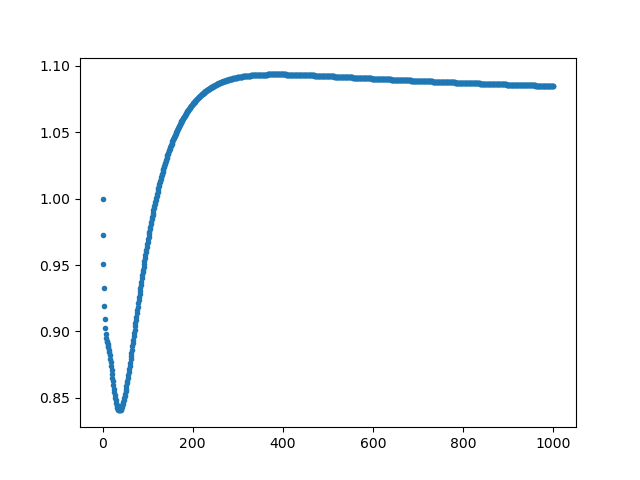

In [45]:
vec = []
for row in nvec:
    vec.append(np.sum(row))


plt.figure()
plt.plot(vec, ".")
plt.show()

<IPython.core.display.Javascript object>


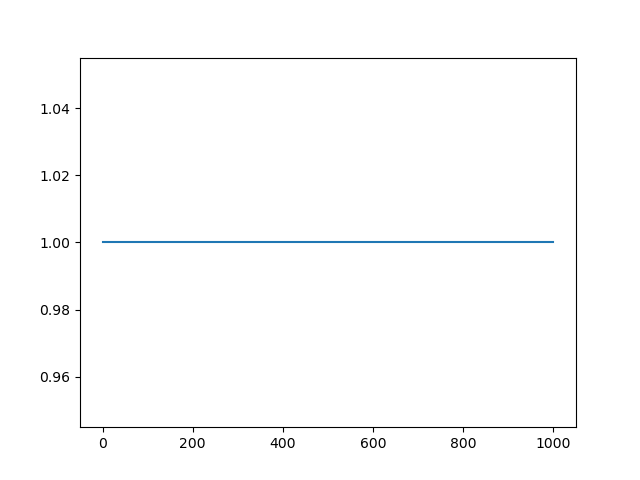

In [46]:
rcvec = []
for i in range(len(rvec)):
    rcvec.append(np.sum(cvec[i]) + np.sum(rvec[i]))
    
plt.figure()
plt.plot(rcvec)
plt.show()

In [47]:
print(cvec[-1])
print(rvec[-1])

[0.00936735 0.00876217 0.00876225 0.00876222 0.00876211 0.00876215
 0.00876214 0.00802562 0.00804203 0.00802503 0.00804273 0.0080253
 0.00804264 0.00802491 0.00804196 0.00802491 0.00804249 0.00802489
 0.00804196 0.00754204 0.0075506  0.00754129 0.0075374  0.00755532
 0.00754224 0.00753731 0.00755517 0.00754176 0.00753644 0.00755371
 0.00753664 0.00754181 0.00755501 0.00753717 0.00754114 0.00755051
 0.00754201 0.00726291 0.00726347 0.0072761  0.00726359 0.00726455
 0.00726972 0.00726949 0.00726251 0.00726501 0.00726948 0.00726791
 0.00726277 0.00726551 0.007268   0.00726325 0.00726765 0.00726907
 0.00726458 0.00726212 0.00726916 0.00726945 0.00726434 0.00726344
 0.007276   0.00726342 0.00717467 0.007188   0.00718034 0.00718098
 0.00718863 0.00717583 0.00717715 0.0071908  0.00717899 0.00717825
 0.00718704 0.00717505 0.00717706 0.00719023 0.00717814 0.00717783
 0.00718682 0.00717504 0.00717733 0.00718987 0.00717981 0.00718844
 0.00717826 0.00717802 0.0071899  0.00717667 0.00717465 0.00718

In [52]:
%%capture
def animate_n(ui, fps):
    dt = 1/fps
    fig, ax = plt.subplots()
    ui = np.array(ui)
    maxVal = np.max(ui)
    print(maxVal)
    
    #x = ui[-1]
    #pcm = ax.tricontourf(p[:,0], p[:,1], tri, x, vmin = 0, vmax = maxVal)
    #fig.colorbar(pcm)
    
    #Method to change the contour plot
    def animate(i):
        ax.clear()
        x = ui[i]
        pcm = ax.tricontourf(p[:,0], p[:,1], tri, x)#, vmin = 0, vmax = maxVal)
        #fig.colorbar(pcm)
    
    
    ani = animation.FuncAnimation(fig, animate, frames = (len(ui)//10), interval=dt*1000, repeat = False)
    
    return HTML(ani.to_jshtml())

ani = animate_n(rvec, 1000)

In [53]:
display(ani)

In [13]:
def plot3D(p, u):
    """
    Takes in a list of (x, y) cordinates p, a numerical solution and an exact solution. Plots the
    numerical solution, exact solution and the error.
    """
    fig = plt.figure(figsize=(18, 6))
    
    ax = fig.add_subplot(1, 3, 1, projection="3d")
    ax.plot_trisurf(p[:, 0], p[:, 1], u, linewidth=0.2)
    ax.set_title("Numerical")